In [131]:
import os
import copy

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from itertools import islice
from rdkit import Chem
import linecache

path = "G:\\Dev\\CSIFingerID\\"
gnps_dir = "G:\\Dev\\Data\\GNPS For Family"
batch_file_dir = path + "ALL_GNPS_20181012_mini_batches"
output_file_dir = path + "all_sirius_output_minibatches"
sample_fingerprints_legend_path = path + "fingerprints.csv"
cdk_fingerprints_legend_path = path + "CDK_fingerprints_smarts.txt"
spectrum_smiles_dir = "G:\\Dev\\Data\\GNPS For Family"
mibig_smiles_file = "G:\\Dev\\Data\\smiles.tsv" 

In [ ]:
from nn_evaluation_interface import plot_loss, compute_auc, evaluate, compute_predicted_family_proportion
from nn_files_load_interface import *
from nn_interface import simplified_fingerprint_model, simplified_family_model
from nn_training_splits_interface import train_diff_splits

In [132]:
spectrum_smiles = {}

for file in os.listdir(spectrum_smiles_dir):
    filepath = os.path.join(spectrum_smiles_dir, file)
    smiles = linecache.getline(filepath, 7)[8:-1]
    spectrum_smiles[file[:-3]] = smiles
    
with open(mibig_smiles_file, 'r') as f:
    for line in f:
        mol_id, smiles = line.split("\t")
        spectrum_smiles[mol_id] = smiles[:-1]

In [109]:
def file_has_fingerprint(file_content):
    return "fingerprints.csv" in file_content

def file_incomplete(file_content):
    return len(file_content) <= 2

def retrieve_fingerprint_file(formula, folder):
    content = os.listdir(folder)
    return next((filename for filename in content if formula in filename), None)

In [110]:
desc_list = []
count = 0
correct_fingerprint_count = 0

with open(sample_fingerprints_legend_path, 'r') as f:
    for line in f:
        rel_index, abs_index, desc = line.split("\t")
        if desc[:-1] != "description":
            desc_list.append(desc[:-1])

desc_list = desc_list[:154]
fingerprint_smarts = [entry.split(" ")[0] for entry in desc_list]

In [111]:
correct_folder_file = []

for directory in os.listdir(output_file_dir):
    file_dir = os.path.join(output_file_dir, directory)
    files_in_output_dir = os.listdir(file_dir)
    if file_has_fingerprint(files_in_output_dir):
        mol = files_in_output_dir[1].split("_")[-1]
        mol_file = os.path.join(gnps_dir, mol + ".ms")
        if os.path.isfile(mol_file):
            with open(mol_file, 'r') as f:
                content = f.readlines()
                formula = content[1].split(" ")[-1][:-1]
        count += 1
        folder = "1_{0}_{1}".format(directory, mol)
        fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
        if retrieve_fingerprint_file(formula, fingerprints_file_dir):
            correct_folder_file.append((directory, mol, formula))
            correct_fingerprint_count += 1

In [112]:
correct_filenames = [entry[1] for entry in correct_folder_file]
print(correct_filenames)

['CCMSLIB00000072234', 'CCMSLIB00000072237', 'CCMSLIB00000075308', 'CCMSLIB00000001606', 'CCMSLIB00000223870', 'CCMSLIB00000223876', 'CCMSLIB00000223902', 'CCMSLIB00000001621', 'CCMSLIB00000424790', 'CCMSLIB00000001623', 'CCMSLIB00000424918', 'CCMSLIB00000424925', 'CCMSLIB00000427300', 'CCMSLIB00000427303', 'CCMSLIB00000001625', 'CCMSLIB00000478584', 'CCMSLIB00000478593', 'CCMSLIB00000478652', 'CCMSLIB00000531504', 'CCMSLIB00000539139', 'CCMSLIB00000001645', 'CCMSLIB00000006290', 'CCMSLIB00000006291', 'CCMSLIB00000006292', 'CCMSLIB00000077108', 'CCMSLIB00000077134', 'CCMSLIB00000072062']


In [156]:
fingerprints_df = pd.DataFrame(0.0, index=correct_filenames, columns=range(len(desc_list)), dtype=float)
print(len(desc_list))

154


In [157]:
for directory, mol, formula in correct_folder_file:
    file_dir = os.path.join(output_file_dir, directory)
    folder = "1_{0}_{1}".format(directory, mol)
    fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
    fingerprint_path = retrieve_fingerprint_file(formula, fingerprints_file_dir)
    full_fingerprint_path = os.path.join(fingerprints_file_dir, fingerprint_path)
    fingerprint_bits = np.loadtxt(full_fingerprint_path, dtype=np.double)
    relevant_fingerprint_bits = fingerprint_bits[:154]
    fingerprints_df.loc[mol] = relevant_fingerprint_bits
    
print("Done")

Done


In [14]:
datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"
filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"

families_path = "G:\\Dev\\Data\\Final Smiles Families.txt"
mibig_families_path = "G:\\Dev\\Data\\mibig_family.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"
num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1

In [151]:
# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_from_smarts(path, number_of_rows=0):
    BITS = 154  # Total number of bits in fingerprint
    
    # number_of_rows to skip, e.g. headers
    fp_all = np.loadtxt(path, dtype="U105", skiprows=number_of_rows)  # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0])  # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index=fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for fp_id in fp_ids:
        smiles = spectrum_smiles[fp_id]
        m = Chem.MolFromSmiles(smiles)
        for index, smarts in enumerate(fingerprint_smarts):
            patt = Chem.MolFromSmarts(smarts)
            fingerprints.at[fp_id, index] = int(m.HasSubstructMatch(patt))

    return fingerprints

In [152]:
spectra = load_master_file(path=datapath).values
fingerprints = load_fingerprints_from_smarts(fingerprints_path, number_of_rows=1)
mibig_fingerprints = load_fingerprints_from_smarts(filtered_fingerprints_path, number_of_rows=1)
families = load_families_master(mibig_families_path)
print(len(mibig_fingerprints))
print(len(families))

print("Done")

1295
1295
Done


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 5884 samples, validate on 654 samples
Epoch 1/100
5884/5884 [==============================] - 3s 457us/step - loss: 0.4599 - val_loss: 0.3079
Epoch 2/100
5884/5884 [==============================] - 2s 303us/step - loss: 0.2644 - val_loss: 0.2605
Epoch 3/100
5884/5884 [==============================] - 2s 326us/step - loss: 0.2485 - val_loss: 0.2504
Epoch 4/100
5884/5884 [==============================] - 2s 330us/step - loss: 0.2434 - val_loss: 0.2456
Epoch 5/100
5884/5884 [==============================] - 2s 336us/step - loss: 0.2400 - val_loss: 0.2425
Epoch 6/100
5884/5884 [==============================] - 2s 328us/step - loss: 0.2372 - val_loss: 0.2400
Epoch 7/100
5884/5884 [==============================] - 2s 333us/step - loss: 0.2348 - val_loss: 0.2379
Epoch 8/100
5884/5884 [==============================] - 2s 338us/step - loss: 0.2325 - val_loss: 0.2361
Epoch 9/100
5884/5884 [==============================] - 2s 341us/step - loss: 0.2304 - val_loss: 0.2343
Epoch 10

Epoch 78/100
5884/5884 [==============================] - 2s 327us/step - loss: 0.1676 - val_loss: 0.2017
Epoch 79/100
5884/5884 [==============================] - 2s 320us/step - loss: 0.1669 - val_loss: 0.2017
Epoch 80/100
5884/5884 [==============================] - 2s 320us/step - loss: 0.1663 - val_loss: 0.2016
Epoch 81/100
5884/5884 [==============================] - 2s 313us/step - loss: 0.1657 - val_loss: 0.2016
Epoch 82/100
5884/5884 [==============================] - 2s 317us/step - loss: 0.1651 - val_loss: 0.2016
Epoch 83/100
5884/5884 [==============================] - 2s 316us/step - loss: 0.1645 - val_loss: 0.2015
Epoch 84/100
5884/5884 [==============================] - 2s 323us/step - loss: 0.1639 - val_loss: 0.2015
Epoch 85/100
5884/5884 [==============================] - 2s 315us/step - loss: 0.1633 - val_loss: 0.2015
Epoch 86/100
5884/5884 [==============================] - 2s 311us/step - loss: 0.1627 - val_loss: 0.2015
Epoch 87/100
5884/5884 [======================

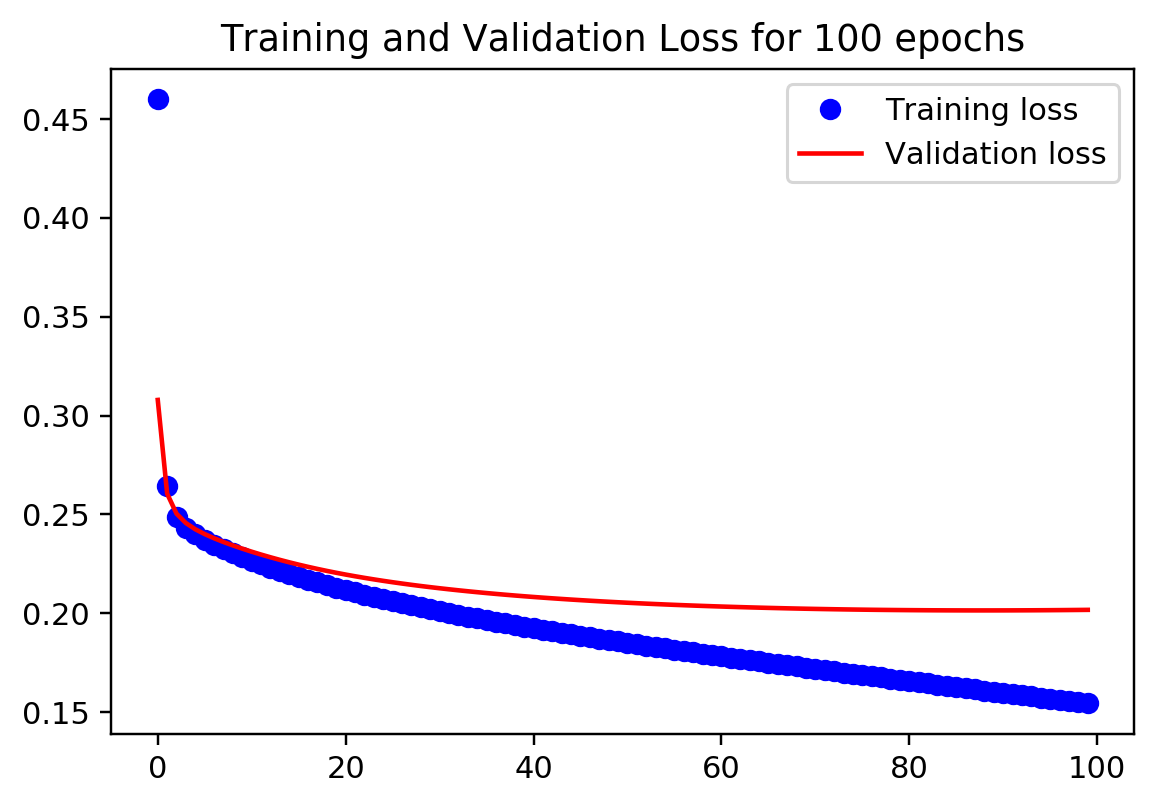

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 1165 samples, validate on 130 samples
Epoch 1/100
1165/1165 [==============================] - 1s 938us/step - loss: 0.5185 - val_loss: 0.3799
Epoch 2/100
1165/1165 [==============================] - 0s 217us/step - loss: 0.3584 - val_loss: 0.3237
Epoch 3/100
1165/1165 [==============================] - 0s 225us/step - loss: 0.3314 - val_loss: 0.3078
Epoch 4/100
1165/1165 [==============================] - 0s 243us/step - loss: 0.3194 - val_loss: 0.2993
Epoch 5/100
1165/1165 [==============================] - 0s 211us/step - loss: 0.3103 - val_loss: 0.2930
Epoch 6/100
1165/1165 [==============================] - 0s 270us/step - loss: 0.3026 - val_loss: 0.2880
Epoch 7/100
1165/1165 [==============================] - 0s 218us/step - loss: 0.2959 - val_loss: 0.2836
Epoch 8/100
1165/1165 [==============================] - 0s 233us/step - loss: 0.2898 - val_loss: 0.2798
Epoch 9/100
1165/1165 [==============================] - 0s 232us/step - loss: 0.2843 - val_loss: 0.2764
Epoch 10

Epoch 78/100
1165/1165 [==============================] - 0s 232us/step - loss: 0.1681 - val_loss: 0.2103
Epoch 79/100
1165/1165 [==============================] - 0s 250us/step - loss: 0.1674 - val_loss: 0.2101
Epoch 80/100
1165/1165 [==============================] - 0s 221us/step - loss: 0.1667 - val_loss: 0.2100
Epoch 81/100
1165/1165 [==============================] - 0s 236us/step - loss: 0.1660 - val_loss: 0.2099
Epoch 82/100
1165/1165 [==============================] - 0s 235us/step - loss: 0.1653 - val_loss: 0.2098
Epoch 83/100
1165/1165 [==============================] - 0s 238us/step - loss: 0.1646 - val_loss: 0.2097
Epoch 84/100
1165/1165 [==============================] - 0s 245us/step - loss: 0.1640 - val_loss: 0.2097
Epoch 85/100
1165/1165 [==============================] - 0s 227us/step - loss: 0.1633 - val_loss: 0.2096
Epoch 86/100
1165/1165 [==============================] - 0s 244us/step - loss: 0.1626 - val_loss: 0.2095
Epoch 87/100
1165/1165 [======================

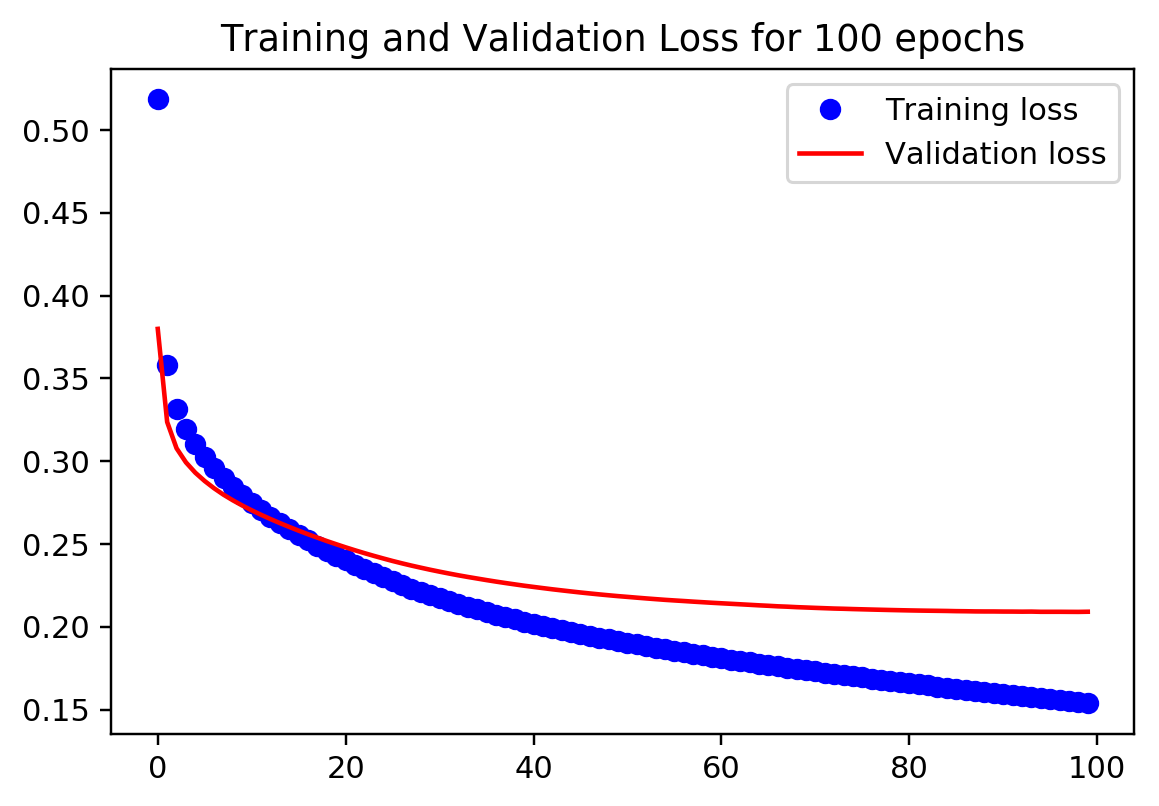

In [153]:
# Example of how to run a fingerprint encoder

# Training network 1 (exclude links)
epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_fingerprints = fingerprints.values

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

# Training network 2 (exclude links)
epochs = 100
x_train_fingerprints = mibig_fingerprints
x_train_families = families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

# gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
# gnps_fingerprints = load_fingerprints_master(linked_fingerprints_path, number_of_rows=1)
# gnps_families = load_families_master(gnps_families_path)

# actual = gnps_families.values
# predicted = enc2.predict(gnps_fingerprints)


# gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
# x_train_families = load_families_master(gnps_families_path)
# x_train_fingerprints = load_fingerprints_master(test_fingerprint_path, number_of_rows=1)

# actual = x_train_families.values
# predicted = enc2.predict(x_train_fingerprints.values)
# exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

# print(exp_stats)
# print()
# print(exp_perm_scores)
# print()

# mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q1.csv"
# mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
# mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

# mibig_gnps_dict = {}
# mibig_families = {}
# mibig_families_count = {}

# for index, row in mibig_gnps_df.iterrows():
#     if row["gnps_id"] not in mibig_gnps_dict:
#         mibig_gnps_dict[row["gnps_id"]] = set()
#     mibig_gnps_dict[row["gnps_id"]].add(row["#mibig_id"])

# with open(mibig_family_path, 'r') as f:
#     for line in f:
#         mibig_id, family = line.split("  ")
#         if mibig_id not in mibig_families:
#             mibig_families[mibig_id] = []
#         mibig_families[mibig_id].append(family[:-1])
        
# probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
# families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
# true_family_counter = {}
# family_correct_counter = {}

# for family in families:
#     true_family_counter[family] = 0
#     family_correct_counter[family] = 0

# with open(probability_report_path, 'w') as f:
#     f.write("#mibig_id,gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")

# with open(probability_report_path, 'a') as f:    
#     for index, probabilities in enumerate(predicted):
#         temp = copy.deepcopy(probabilities).tolist()
#         gnps_id = x_train_fingerprints.index[index]
#         prob_string = ",".join(map(str, probabilities))
#         for mibig_id in mibig_gnps_dict[gnps_id]:
#             true_labels = []
#             max_indexes = []
#             for true_family in mibig_families[mibig_id]:
#                 true_labels.append(true_family)
#                 max_index = temp.index(max(temp))
#                 max_indexes.append(max_index)
#                 temp.remove(temp[max_index])
#                 true_family_counter[true_family] += 1
#                 f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")
#             for index in max_indexes:
#                 if families[index] in true_labels:
#                     family_correct_counter[families[index]] += 1
    
# prediction_comparison_report_path = "G:\\Dev\\Data\\prediction_comparison_report.txt"
# with open(prediction_comparison_report_path, 'w') as f:
#     f.write("family,matched,actual,proportion\n")

# with open(prediction_comparison_report_path, 'a') as f:
#     for family in family_correct_counter:
#         matched = family_correct_counter[family]
#         actual = true_family_counter[family]
#         proportion = 0
#         if actual != 0:
#             proportion = matched / actual
#         f.write(family + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")
    
# print("Done")

In [154]:
test_datapath = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"

x_train_spectra = load_master_file(path=test_datapath)

predicted_fingerprints = enc1.predict(x_train_spectra.values)

gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)

actual = x_train_families.values
predicted = enc2.predict(predicted_fingerprints) # using predicted fingerprints

['CCMSLIB00000001550', 'CCMSLIB00000001555', 'CCMSLIB00000001565', 'CCMSLIB00000001569', 'CCMSLIB00000001602', 'CCMSLIB00000001604', 'CCMSLIB00000001606', 'CCMSLIB00000001607', 'CCMSLIB00000001615', 'CCMSLIB00000001616', 'CCMSLIB00000001621', 'CCMSLIB00000001622', 'CCMSLIB00000001623', 'CCMSLIB00000001624', 'CCMSLIB00000001625', 'CCMSLIB00000001635', 'CCMSLIB00000001637', 'CCMSLIB00000001645', 'CCMSLIB00000001651', 'CCMSLIB00000001653', 'CCMSLIB00000001655', 'CCMSLIB00000001756', 'CCMSLIB00000001776', 'CCMSLIB00000001777', 'CCMSLIB00000001778', 'CCMSLIB00000001784', 'CCMSLIB00000004459', 'CCMSLIB00000004694', 'CCMSLIB00000004912', 'CCMSLIB00000005337', 'CCMSLIB00000006289', 'CCMSLIB00000006292', 'CCMSLIB00000006841', 'CCMSLIB00000006864', 'CCMSLIB00000006865', 'CCMSLIB00000006866', 'CCMSLIB00000006867', 'CCMSLIB00000006868', 'CCMSLIB00000006869', 'CCMSLIB00000006871', 'CCMSLIB00000006901', 'CCMSLIB00000006902', 'CCMSLIB00000006903', 'CCMSLIB00000070263', 'CCMSLIB00000070270', 'CCMSLIB0

In [155]:
print(compute_auc(8, actual, predicted))

Done
(array([(0, 14, 0.74012158,   0. ), (1, 63, 0.6782003 ,   0. ),
       (2,  7, 0.71501832,   4.4), (3, 12, 0.80394737,   0. ),
       (4,  0, 0.        , 100. ), (5, 10, 0.671875  ,   3.2),
       (6, 91, 0.68547669,   0. ), (7, 23, 0.62861307,   0.6)],
      dtype=[('fp_id', '<i4'), ('nonzeros', '<i4'), ('auc', '<f8'), ('auc_percent', '<f8')]), array([[0.63107903, 0.4156535 , 0.51025836, ..., 0.41261398, 0.52241641,
        0.63297872],
       [0.52106886, 0.54413612, 0.45894713, ..., 0.51273267, 0.44695672,
        0.53888318],
       [0.47472527, 0.42783883, 0.47912088, ..., 0.4974359 , 0.64761905,
        0.30549451],
       ...,
       [0.60208333, 0.465625  , 0.3328125 , ..., 0.50416667, 0.28645833,
        0.52239583],
       [0.48460548, 0.48618949, 0.53687754, ..., 0.5035145 , 0.50688051,
        0.49203049],
       [0.53218363, 0.44158368, 0.47486034, ..., 0.58489191, 0.51712412,
        0.46951664]]))


In [159]:
# careful, the spectrum id is different
filtered_families = x_train_families[x_train_families.index.isin(correct_filenames)]
filtered_families.sort_index(inplace=True)

actual = filtered_families.values
filtered_fingerprints_df = fingerprints_df[fingerprints_df.index.isin(filtered_families.index)]
filtered_fingerprints_df.sort_index(inplace=True)

predicted = enc2.predict(filtered_fingerprints_df.values)
print(list(filtered_fingerprints_df.index))
print(list(filtered_families.index))

print(compute_auc(8, actual, predicted))

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


['CCMSLIB00000001606', 'CCMSLIB00000001621', 'CCMSLIB00000001623', 'CCMSLIB00000001625', 'CCMSLIB00000001645', 'CCMSLIB00000006292', 'CCMSLIB00000072062', 'CCMSLIB00000072234', 'CCMSLIB00000072237', 'CCMSLIB00000075308', 'CCMSLIB00000077108', 'CCMSLIB00000077134', 'CCMSLIB00000223870', 'CCMSLIB00000223876', 'CCMSLIB00000223902', 'CCMSLIB00000424790', 'CCMSLIB00000424918', 'CCMSLIB00000424925', 'CCMSLIB00000427300', 'CCMSLIB00000427303', 'CCMSLIB00000478584', 'CCMSLIB00000478593', 'CCMSLIB00000478652', 'CCMSLIB00000531504', 'CCMSLIB00000539139']
['CCMSLIB00000001606', 'CCMSLIB00000001621', 'CCMSLIB00000001623', 'CCMSLIB00000001625', 'CCMSLIB00000001645', 'CCMSLIB00000006292', 'CCMSLIB00000072062', 'CCMSLIB00000072234', 'CCMSLIB00000072237', 'CCMSLIB00000075308', 'CCMSLIB00000077108', 'CCMSLIB00000077134', 'CCMSLIB00000223870', 'CCMSLIB00000223876', 'CCMSLIB00000223902', 'CCMSLIB00000424790', 'CCMSLIB00000424918', 'CCMSLIB00000424925', 'CCMSLIB00000427300', 'CCMSLIB00000427303', 'CCMSLIB